## Enhanced Deep Residual Networks for Single Image Super-Resolution
The following notebook is an attempt to implement https://arxiv.org/pdf/1707.02921.pdf
The following implementation trains a model to super resolve input images at 4x level. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# from fastestimator.dataset import div2k, flickr2k
# import fastestimator as fe
# import matplotlib.pyplot as plt
# import pandas as pd
# import cv2
# import os
# import numpy as np
# from fastestimator.op.numpyop import ImageReader
# from fastestimator.op import TensorOp, NumpyOp
# import tensorflow as tf
# from fastestimator.layers.sub_pixel_conv_2d import SubPixelConv2D
# from fastestimator.schedule.lr_scheduler import LRSchedule
# from fastestimator.op.tensorop import Loss, ModelOp
# from fastestimator.schedule.lr_scheduler import LRSchedule
# from fastestimator.trace import LRController, ModelSaver
# from fastestimator.op.tensorop.augmentation import Augmentation2D, SRAugmentation2D

In [13]:
MAX_RESOLUTION=2040  # max resolution of across div2k images is 2040x2040

#### Downloading  div2k dataset to local storage. 

In [4]:
train_div2k_csv, val_div2k_csv,  path_div2k = div2k.load_data('/home/ubuntu/fastestimator_data/DRLN', lr_scale=2)
path_drln = path_div2k
df_div2k  = pd.read_csv(train_div2k_csv)
df = df_div2k
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df.head()

image_hr  \
0  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...   
1  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...   
2  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...   
3  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...   
4  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...   

                                            image_lr  
0  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...  
1  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...  
2  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...  
3  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...  
4  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...

#### Let us inspect the data we are dealing with.

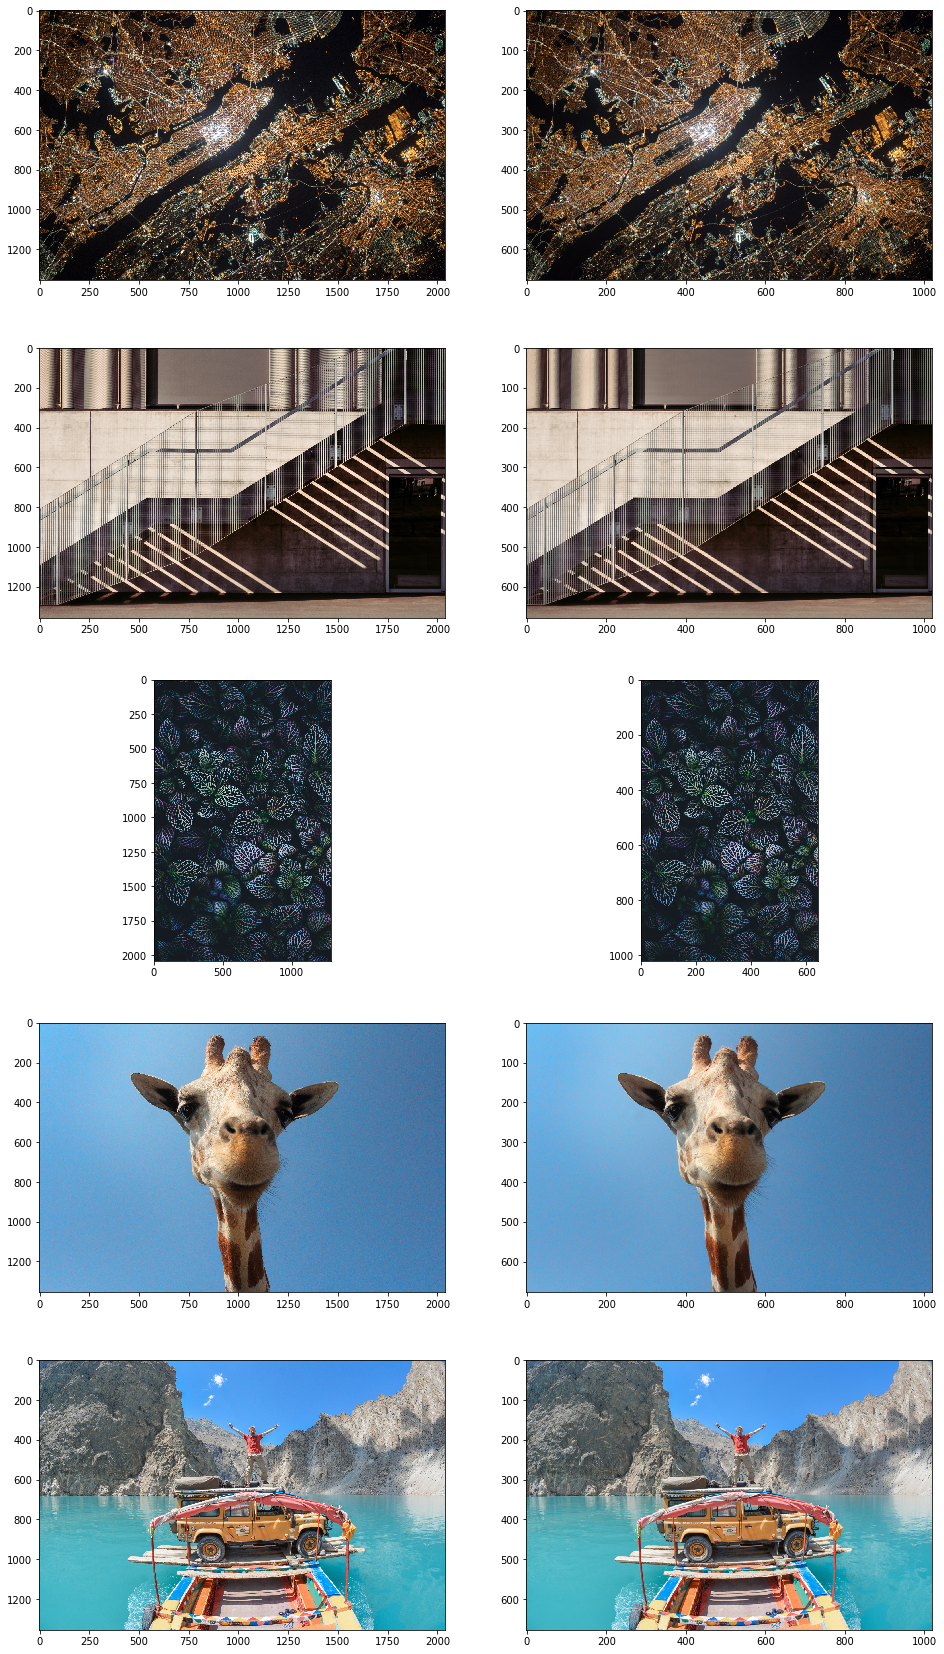

In [15]:
num_imgs_to_show = 5
start_range = 0 
end_range = start_range + num_imgs_to_show
fig, axes = plt.subplots(nrows=num_imgs_to_show,ncols=2)
fig.set_figwidth(16)
fig.set_figheight(30)
for idx,(img_hr_path, img_lr_path) in enumerate(zip(df['image_hr'].values[start_range:end_range],
                                                    df['image_lr'].values[start_range:end_range])):
    img_hr = cv2.imread(img_hr_path)
    img_hr =  cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    img_lr = cv2.imread(img_lr_path)
    img_lr =  cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    
    axes[idx][0].imshow(img_hr)
    axes[idx][1].imshow(img_lr)
plt.show()


#### Samples Images are not consistent across height and width. Resorted to padding to make them consistent across height and width.  Sample image takes up top left portion of the resultant padded image.

In [15]:
class PadUptoTargetShape(NumpyOp):
    """Preprocessing class for padding the data

    Args:
        shape: target shape
    """
    def __init__(self, shape,inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.target_shape = shape

    def forward(self, data, state):
        """Pad data array

        Args:
            data: Data to be padded
            state: A dictionary containing background information such as 'mode'

        Returns:
            Padded array
        """
        input_shape = data.shape
        required_height_padding = self.target_shape[0] - input_shape[0]
        required_weight_padding = self.target_shape[1] - input_shape[1]
        pad_sequence = [(0, required_height_padding),(0, required_weight_padding),(0,0)]
        data_padded = np.pad(data,pad_sequence,mode='constant')
        return data_padded, input_shape

#### Record writer step
ImageReader along with above mentioned padding op carried on the sample images.

In [16]:
 writer = fe.RecordWriter(
        save_dir=os.path.join(path_div2k, "tfrecords"),
        train_data=train_div2k_csv,
        validation_data=val_div2k_csv,
        ops=[ImageReader(inputs="image_hr", outputs="image_hr"), 
             ImageReader(inputs="image_lr", outputs="image_lr"),
             PadUptoTargetShape((1020, 1020),inputs='image_lr',outputs=['image_lr','lr_shape']),
             PadUptoTargetShape((2040,2040),inputs='image_hr',outputs=['image_hr','hr_shape'])
             ],
        compression="GZIP",
        write_feature=['image_hr', 'hr_shape', 'image_lr', 'lr_shape'])

#### Rescale Op to keep values between 0 and 1 rather than  0 and 255. This is a pipeline operation.

In [17]:
class Rescale(TensorOp):
    """Rescaling data according to

    Args:
        inputs: Name of the key in the dataset that is to be filtered.
        outputs: Name of the key to be created/used in the dataset to store the results.
        mode: mode that the filter acts on.
    """
    def __init__(self, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)

    def forward(self, data, state):
        data = tf.cast(data, tf.float32)
        data /= 255
        return data

#### RandomImagePatches Op . The original images are captured from the padded images. From those images a patch is generated. The patch size is passed as argument. The scale is another argument, ratio between low res and high res.

In [19]:
class RandomImagePatches(TensorOp):
    """ RandomImagePatches generates crops. These crops are defined by patch_size
    """
    def __init__(self,
                 inputs=None,
                 outputs=None,
                 mode=None,
                 lr_patch_size=(48,48), scale=2):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.lr_patch_size = lr_patch_size
        self.scale = scale

    def get_image_patch(self, image_hr, image_lr, lr_shape):
        offset_height_lr = tf.random.uniform(shape=(1, ), minval=0, 
                                          maxval= lr_shape[0]- self.lr_patch_size[0]+1, dtype=tf.dtypes.int32)
        offset_width_lr = tf.random.uniform(shape=(1, ), minval=0, 
                                         maxval= lr_shape[1]- self.lr_patch_size[1]+1, dtype=tf.dtypes.int32)
        crop_img_lr = image_lr[offset_height_lr[0]:offset_height_lr[0]+ self.lr_patch_size[0], 
                               offset_width_lr[0]:offset_width_lr[0]+ self.lr_patch_size[1]]
        
        offset_height_hr = offset_height_lr[0]* self.scale
        offset_width_hr =  offset_width_lr[0]* self.scale
        hr_patch_size = (self.lr_patch_size[0]*self.scale, self.lr_patch_size[1]*self.scale)
        crop_img_hr = image_hr[offset_height_hr:offset_height_hr + hr_patch_size[0], 
                               offset_width_hr:offset_width_hr + hr_patch_size[1]]
        
        return crop_img_hr, crop_img_lr

    def forward(self, data, state):
        image_hr, hr_shape, image_lr, lr_shape = data
        image_hr = image_hr[0:hr_shape[0],0:hr_shape[1],:]
        image_lr = image_lr[0:lr_shape[0],0:lr_shape[1],:]
        crop_img_hr, crop_img_lr = self.get_image_patch(image_hr,image_lr, lr_shape)
        return crop_img_hr , crop_img_lr

#### Pipeline initialization

In [20]:
pipeline = fe.Pipeline(
    batch_size=16,
    data=writer,
    ops=[  RandomImagePatches(inputs=['image_hr','hr_shape','image_lr','lr_shape'], outputs=['image_hr','image_lr']),
#          SRAugmentation2D(inputs=['image_hr','image_lr'], outputs=['image_hr', 'image_lr'], mode='train'), 
         Rescale(inputs='image_hr', outputs='image_hr'), Rescale(inputs='image_lr',  outputs='image_lr')])


#### Let's inspect the sample images after the pipeline stage

In [83]:
sample_batch= pipeline.show_results()

FastEstimator: Saving tfrecord to /home/ubuntu/fastestimator_data/DRLN/tfrecords
FastEstimator: Converting Train TFRecords 0.0%, Speed: 0.00 record/sec
FastEstimator: Converting Train TFRecords 5.0%, Speed: 7.97 record/sec
FastEstimator: Converting Train TFRecords 10.0%, Speed: 8.37 record/sec
FastEstimator: Converting Train TFRecords 15.0%, Speed: 8.21 record/sec
FastEstimator: Converting Train TFRecords 20.0%, Speed: 8.10 record/sec
FastEstimator: Converting Train TFRecords 25.0%, Speed: 9.00 record/sec
FastEstimator: Converting Train TFRecords 30.0%, Speed: 8.55 record/sec
FastEstimator: Converting Train TFRecords 35.0%, Speed: 8.83 record/sec
FastEstimator: Converting Train TFRecords 40.0%, Speed: 7.99 record/sec
FastEstimator: Converting Train TFRecords 45.0%, Speed: 8.00 record/sec
FastEstimator: Converting Train TFRecords 50.0%, Speed: 8.05 record/sec
FastEstimator: Converting Train TFRecords 55.0%, Speed: 8.26 record/sec
FastEstimator: Converting Train TFRecords 60.0%, Speed: 8

In [84]:
image_hr = sample_batch[0]['image_hr']
image_lr = sample_batch[0]['image_lr']

In [85]:
image_hr.shape, image_lr.shape

(TensorShape([16, 96, 96, 3]), TensorShape([16, 48, 48, 3]))

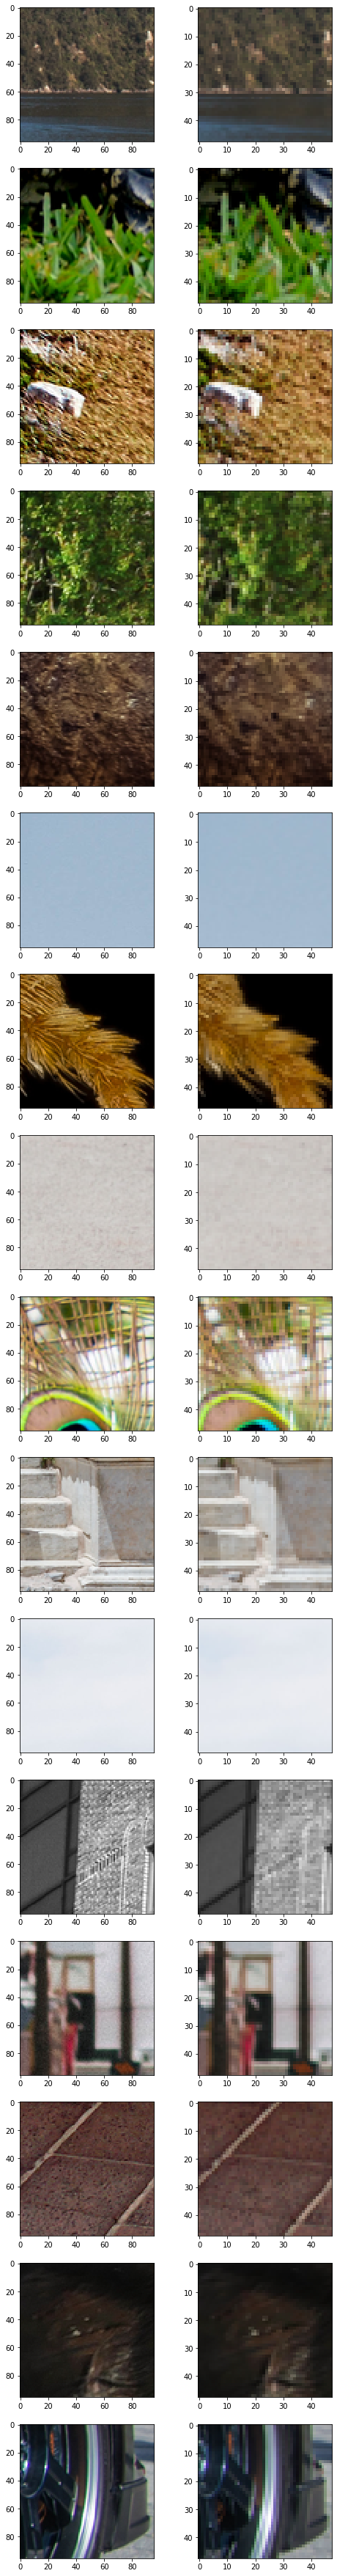

In [86]:
num_imgs_to_show = 16
fig, axes = plt.subplots(nrows=num_imgs_to_show,ncols=2)
fig.set_figwidth(8)
fig.set_figheight(64)
for idx,(img_hr, img_lr) in enumerate(zip(image_hr,image_lr)):
    axes[idx][0].imshow(img_hr)
    axes[idx][1].imshow(img_lr)
plt.show()

#### EDSR increments and network 

![title](images/edsr1.png)

![title](images/edsr2.png)

In [22]:
# Enhanced Deep Residual Networks for Single Image Super-Resolution
def res_block(layer, filters=64, res_scale=1):  
    temp = layer
    layer = Conv2D(filters,3,padding='same')(layer)    
    layer = Activation('relu')(layer)
    layer = Conv2D(filters,3,padding='same')(layer)
    layer = layer * res_scale
    layer = temp + layer 
    return layer

def upsample_block(layer, filters, scale):
    for _ in range(int(np.math.log(scale,2))):
        layer = Conv2D(filters*4,3,padding='same')(layer)
        layer = SubPixelConv2D(upsample_factor=2, nchannels=filters)(layer)
    return layer
    
    
def edsr_network(input_shape=(32,32,3), filters=64, res_blocks=32, scale=4):
    inputs = Input(input_shape)
    
    bias_neg = tf.constant_initializer(np.array([-0.4488, -0.4371, -0.4040]))
    bias_pos = tf.constant_initializer(np.array([0.4488, 0.4371, 0.4040]))
    kernel_init = tf.constant_initializer(np.array([[[[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]]]]))
    meanshifted_inputs= Conv2D(3,1,bias_initializer=bias_neg, kernel_initializer=kernel_init, trainable=False)(inputs)
    
    head = Conv2D(filters,3,padding='same')(meanshifted_inputs)
    x = head
    #===============================================================
    
    for i in range(res_blocks):
        x = res_block(x, filters=filters, res_scale=0.1)
    
    x = Conv2D(filters, 3, padding='same')(x)
    x = x + head
    
    x = upsample_block(x, filters, scale)
    final_out = Conv2D(3,3,padding='same')(x)
    #  reverse operation of mean shift
    final_out= Conv2D(3,1, bias_initializer=bias_pos, kernel_initializer=kernel_init, trainable=False)(final_out)
    return Model(inputs=inputs, outputs=final_out)
    
    

    
    

#### Mean Average loss is chosen as the error. Note it is not mean square error.

In [ ]:
class ContentLoss(Loss):
    """Compute generator loss."""
    def __init__(self, inputs, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.mae_loss =  tf.keras.losses.MeanAbsoluteError(reduction='none')

    def forward(self, data, state):
        superres, highres = data
        batch_size, _, _, _ = superres.shape
        superres = tf.reshape(superres, (batch_size, -1))
        highres = tf.reshape(highres, (batch_size, -1))
        mae_loss = self.mae_loss(highres, superres)
        return mae_loss

#### LR is selected as 1e-4 , subsequently reduced by 2 every 200000 iterations.

In [23]:
class MyLRSchedule(LRSchedule):
    """ lrschedule to modify lr for edsr.  """
    def __init__(self, schedule_mode):
        super().__init__(schedule_mode)
        self.current = 0
    def schedule_fn(self, current_step_or_epoch, lr):
        next = current_step_or_epoch//200000
        if self.current != next:
            lr = lr/2
            self.current = next
        return lr

#### Model and Network 

In [19]:
 model_drln = fe.build(model_def= lambda: edsr_network(input_shape=(48,48,3), filters=256, scale=2),
                          model_name="edsr",
                          optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                          loss_name="mae_loss")


NameError: name 'edsr_network' is not defined

In [ ]:
network = fe.Network(ops=[
        ModelOp(inputs='image_lr', model=model_drln, outputs='image_sr'),
        ContentLoss(inputs=("image_sr", "image_hr"), outputs=("mae_loss")),
    ])

#### Estimator

In [26]:
model_dir = os.path.join(path_div2k)
estimator = fe.Estimator(
    network=network,
    pipeline=pipeline,
    steps_per_epoch=100,
    epochs=3000,
    traces=[
        ModelSaver(model_name="edsr", save_dir=model_dir, save_best=True),
        LRController(model_name="edsr", lr_schedule=MyLRSchedule(schedule_mode='step'))
    ])

#### Training begins ...

In [20]:
estimator.fit()

#### Inference

In [27]:
model_drln.load_weights(os.path.join(path_drln, 'edsr_best_mae_loss.h5' ))

In [ ]:
sample_batch = pipeline.show_results(mode='train')

FastEstimator: Reading non-empty directory: /home/ubuntu/fastestimator_data/DRLN/tfrecords
FastEstimator: Found 800 examples for train in /home/ubuntu/fastestimator_data/DRLN/tfrecords/train_summary0.json
FastEstimator: Found 100 examples for eval in /home/ubuntu/fastestimator_data/DRLN/tfrecords/eval_summary0.json


In [ ]:
sample_batch[0]['image_hr'].shape, sample_batch[0]['image_lr'].shape

In [61]:
image_sr_validation = model_drln(sample_batch[0]['image_lr'])

In [62]:
image_hr_numpy = sample_batch[0]['image_hr'].numpy()
image_lr_numpy = sample_batch[0]['image_lr'].numpy()
image_sr_numpy = image_sr_validation.numpy()
print(image_sr_numpy.shape)
# image_sr_numpy = image_sr_numpy[:::-1]

(16, 96, 96, 3)


NameError: name 'image_lr_numpy' is not defined

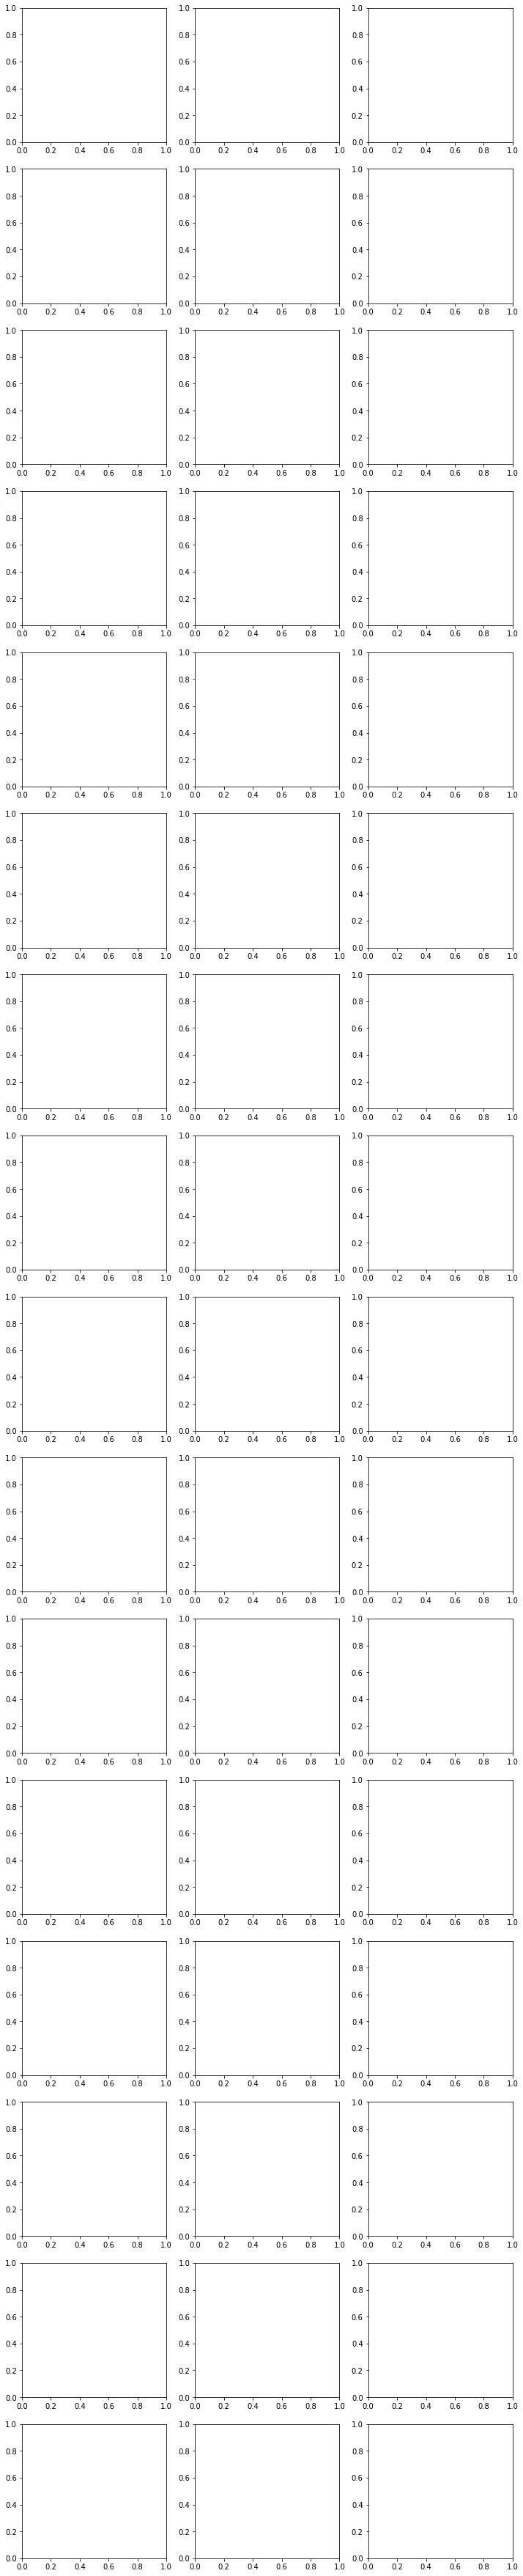

In [22]:
fig, axes = plt.subplots(nrows=16, ncols=3)
fig.set_figwidth(12)
fig.set_figheight(64)
for i in range(16):
    axes[i][0].imshow(image_lr_numpy[i])
    axes[i][1].imshow(image_hr_numpy[i])
    axes[i][2].imshow(image_sr_numpy[i][...,::1])
plt.show()